In [39]:
# IMPORTS & CONFIG
import os, json, warnings, traceback
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import neurokit2 as nk
import joblib, pickle
import re
from datetime import datetime
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from scipy.stats import pearsonr, ttest_ind

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')


In [40]:
# Paths
ROOT = Path('/teamspace/studios/this_studio/ubfc_testing')
DATA_PATH = ROOT / 'ubfc_2'
MODEL_OUTPUT_PATH = ROOT / 'best_models'
OUT_DIR = ROOT / 'output'

In [41]:
# Check available subjects(will be called in full run)
subs = []
for p in sorted(DATA_PATH.glob('s*')):
    if p.is_dir():
        sid = re.sub(r'[^0-9]', '', p.name)
        if sid:
            # require at least one BVP file to exist
            bvp_files = list(p.glob('bvp_*_T*.csv'))
            if bvp_files:
                subs.append(sid)
SUBJECT_IDS = subs
TASKS = ['T1','T2','T3']
print('Subjects discovered:', SUBJECT_IDS)
print('N subjects =', len(SUBJECT_IDS), '| Tasks =', TASKS)

Subjects discovered: ['10', '11', '12', '13', '14', '15', '16', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '40', '41', '42', '6', '7', '8', '9']
N subjects = 24 | Tasks = ['T1', 'T2', 'T3']


In [42]:
# Dataset parameters
SAMPLING_RATE = 64  # UBFC BVP is 64 Hz.
WINDOW_SIZE_SEC = 120  
WINDOW_STEP_SEC = 60  
TASKS = ['T1','T2','T3']
SUBJECTS = [6,7,8,9,10,11,12,13,14,15,16,29,30,31,32,33,34,35,36,37,40,41,42]
LABEL_MAP = {'T1':0, 'T2':1, 'T3':1}  # Binary labels(cognitive and social stress are bundled)
scenario_map = {'T1':'ctrl','T2':'test','T3':'test'}

# Model expects 10 core features ( check features json to learn more about why included)
CORE10 = [
    "HRV_SDNN",
    "HRV_RMSSD",
    "HRV_pNN50",
    "HRV_MeanNN",
    "HRV_HF",
    "HRV_LF",
    "HRV_LFHF",
    "HRV_TP",
    "HRV_SampEn",
    "HRV_ApEn"
]

In [43]:
# UTILS: BVP -> RR

def load_bvp(path: Path):
    return pd.read_csv(path, header=None).values.flatten()

def clean_bvp(x, fs=SAMPLING_RATE):
    return nk.ppg_clean(x, sampling_rate=fs)

def detect_peaks(cleaned, fs=SAMPLING_RATE):
    pk = nk.ppg_peaks(cleaned, sampling_rate=fs)[1]['PPG_Peaks']
    return pk

def rr_from_peaks(peaks, fs=SAMPLING_RATE):
    # RR in ms from peak index differences
    rr_samples = np.diff(peaks)
    return (rr_samples / fs) * 1000.0

def filter_rr(rr_ms, min_rr=300, max_rr=2000):
    rr = np.asarray(rr_ms).flatten()
    mask = (rr >= min_rr) & (rr <= max_rr)
    return rr[mask]

def quick_plots(bvp, cleaned, peaks, rr, rr_filt, title_prefix=''):
    t = np.arange(len(bvp))/SAMPLING_RATE
    fig, axes = plt.subplots(2,2, figsize=(14,8))
    axes[0,0].plot(t, bvp, lw=0.5); axes[0,0].set_title(f'{title_prefix} Raw BVP')
    axes[0,1].plot(t, cleaned, lw=0.5); axes[0,1].scatter(t[peaks], cleaned[peaks], s=10, c='r'); axes[0,1].set_title('Cleaned + Peaks')
    axes[1,0].plot(rr, marker='o', lw=0.8); axes[1,0].axhline(300,color='r',ls='--'); axes[1,0].axhline(2000,color='r',ls='--'); axes[1,0].set_title('RR (ms)')
    axes[1,1].plot(rr_filt, marker='o', lw=0.8); axes[1,1].set_title('RR filtered (ms)')
    plt.tight_layout(); plt.show()
    print('Peaks:', len(peaks), '| RR:', len(rr), '| RR_filtered:', len(rr_filt))

print('BVP→RR utilities ready.')

BVP→RR utilities ready.


In [44]:
# WINDOWING using slide window to extract two 120 sec with 60 sec overlap

def extract_windows(rr_ms, window_size_sec=WINDOW_SIZE_SEC, step_size_sec=WINDOW_STEP_SEC):
    rr = np.asarray(rr_ms).flatten()
    if rr.size == 0:
        return [], []
    beats_sec = np.cumsum(np.concatenate([[0], rr/1000.0]))  # beat times in sec
    total = beats_sec[-1]
    windows, meta = [], []
    start, idx = 0.0, 0
    while start < total:  # keep sliding as long as start is before signal ends
        end = start + window_size_sec
        if end > total:  # adjust window to end exactly at signal end
            end = total
        mask = (beats_sec[:-1] >= start) & (beats_sec[1:] <= end)
        seg = rr[mask]
        if seg.size >= 2:
            windows.append(seg)
            meta.append({'window_index': idx, 'start_sec': float(start), 'end_sec': float(end), 'rr_count': int(seg.size)})
        idx += 1
        start += step_size_sec

    return windows, meta

In [45]:
# METADATA LOADERS(used only for reporting purposes not for val)

def load_subject_info(subject_id, base=DATA_PATH):
    sid = str(subject_id)
    base_dir = Path(base) / f's{sid}'
    candidates = [base_dir / f'info_s{sid}.txt', base_dir / f'infos_{sid}.txt']
    target = None
    for c in candidates:
        if c.exists(): target = c; break
    if target is None:
        return {'subject_id': sid, 'gender': np.nan, 'scenario': 'unknown', 'date': np.nan, 'time': np.nan}
    lines = []
    with open(target, 'r', encoding='utf-8', errors='ignore') as f:
        for raw in f.readlines():
            s = raw.strip()
            if s: lines.append(s)
            if len(lines) >= 5: break
    while len(lines) < 5: lines.append(np.nan)
    subj, gender, scenario, date, t = lines[:5]
    return {'subject_id': sid, 'gender': gender, 'scenario': scenario, 'date': date, 'time': t}


def load_self_reported_anxiety(subject_id, base=DATA_PATH):
    sid = str(subject_id)
    fpath = Path(base) / f's{sid}' / f'selfReportedAnx_s{sid}.csv'
    if not fpath.exists():
        return {'subject_id': sid, 'cognitive_pre': np.nan, 'cognitive_post': np.nan, 'cognitive_change': np.nan,
                'somatic_pre': np.nan, 'somatic_post': np.nan, 'somatic_change': np.nan,
                'confidence_pre': np.nan, 'confidence_post': np.nan, 'confidence_change': np.nan}
    df = pd.read_csv(fpath, header=None).astype(float)
    cog_pre, cog_post = df.iloc[0].tolist()
    som_pre, som_post = df.iloc[1].tolist()
    con_pre, con_post = df.iloc[2].tolist()
    return {'subject_id': sid,
            'cognitive_pre': cog_pre, 'cognitive_post': cog_post, 'cognitive_change': cog_post-cog_pre,
            'somatic_pre': som_pre, 'somatic_post': som_post, 'somatic_change': som_post-som_pre,
            'confidence_pre': con_pre, 'confidence_post': con_post, 'confidence_change': con_post-con_pre}

print('Metadata loaders ready.')

Metadata loaders ready.


In [46]:
# HRV extraction for a window
def hrv_from_rr_window(rr_ms, fs=SAMPLING_RATE):
    rr = np.asarray(rr_ms).flatten()
    if rr.size < 2:
        return None
    rr_sec = rr / 1000.0
    peaks = np.round(np.cumsum(np.concatenate([[0], rr_sec])) * fs).astype(int)
    try:
        hrv = nk.hrv(peaks=peaks, sampling_rate=fs, show=False)
        return hrv
    except Exception as e:
        print('[HRV] extraction failed:', e)
        return None

In [47]:
# Map NeuroKit HRV output to CORE10 features
def map_to_core10(hrv_df, rr_ms_window):
    if hrv_df is None or hrv_df.empty:
        return None
    row = hrv_df.iloc[0]
    try:
        mean_rr = float(row.get('HRV_MeanNN', np.nan))
        hr_mean = 60000.0 / mean_rr if mean_rr and np.isfinite(mean_rr) and mean_rr > 0 else np.nan

        core10 = {
            'HRV_SDNN': float(row.get('HRV_SDNN', np.nan)),
            'HRV_RMSSD': float(row.get('HRV_RMSSD', np.nan)),
            'HRV_pNN50': float(row.get('HRV_pNN50', np.nan)),
            'HRV_MeanNN': mean_rr,
            'HRV_HF': float(row.get('HRV_HF', np.nan)),
            'HRV_LF': float(row.get('HRV_LF', np.nan)),
            'HRV_LFHF': float(row.get('HRV_LFHF', np.nan)),
            'HRV_TP': float(row.get('HRV_TP', np.nan)),
            'HRV_SampEn': float(row.get('HRV_SampEn', np.nan)),
            'HRV_ApEn': float(row.get('HRV_ApEn', np.nan)),
            'HR_mean': hr_mean  # optional, derived from MeanNN
        }
        return core10
    except Exception as e:
        print('[CORE10] mapping failed:', e)
        return None


In [48]:
# PROCESS ONE TASK FILE (returns per-window CORE10 rows + metadata)
def process_task_file(subject_id, task, base=DATA_PATH, fs=SAMPLING_RATE, plot=True):
    sid = str(subject_id)
    path = Path(base)/f's{sid}'/f'bvp_s{sid}_{task}.csv'
    if not path.exists():
        print('[SKIP] missing', path)
        return pd.DataFrame(), {'subject_id': sid, 'task': task, 'windows': 0}

    # Load and preprocess BVP
    bvp = load_bvp(path)
    cleaned = clean_bvp(bvp, fs)
    peaks = detect_peaks(cleaned, fs)
    rr = rr_from_peaks(peaks, fs)
    rr_f = filter_rr(rr)

    if plot:
        quick_plots(bvp, cleaned, peaks, rr, rr_f, title_prefix=f's{sid} {task}')

    # Extract sliding windows (120s window, 60s step)
    wins, meta = extract_windows(rr_f)

    rows = []
    for m, rr_w in zip(meta, wins):
        hrv = hrv_from_rr_window(rr_w, fs)
        core = map_to_core10(hrv, rr_w)  
        if core is None:
            continue

        # Add metadata
        core.update({
            'subject_id': sid,
            'task': task,
            'label': LABEL_MAP[task],
            'window_index': m['window_index'],
            'window_start_sec': m['start_sec'],
            'window_end_sec': m['end_sec'],
            'rr_count_window': m['rr_count']
        })

        # RR stats per window
        core['RR_mean_ms_window'] = float(np.mean(rr_w)) if len(rr_w) else np.nan
        core['RR_sd_ms_window'] = float(np.std(rr_w)) if len(rr_w) else np.nan

        rows.append(core)

    # Build DataFrame
    df = pd.DataFrame(
        rows,
        columns=CORE10 + [
            'HR_mean',  # derived from MeanNN
            'subject_id','task','label','window_index',
            'window_start_sec','window_end_sec','rr_count_window',
            'RR_mean_ms_window','RR_sd_ms_window'
        ]
    )

    summary = {
        'subject_id': sid,
        'task': task,
        'signal_sec': len(bvp)/fs,
        'peaks': int(len(peaks)),
        'rr_total': int(len(rr)),
        'rr_filtered': int(len(rr_f)),
        'windows': int(df.shape[0])
    }

    return df, summary


print('Single task processor ready with CORE10 features.')


Single task processor ready with CORE10 features.


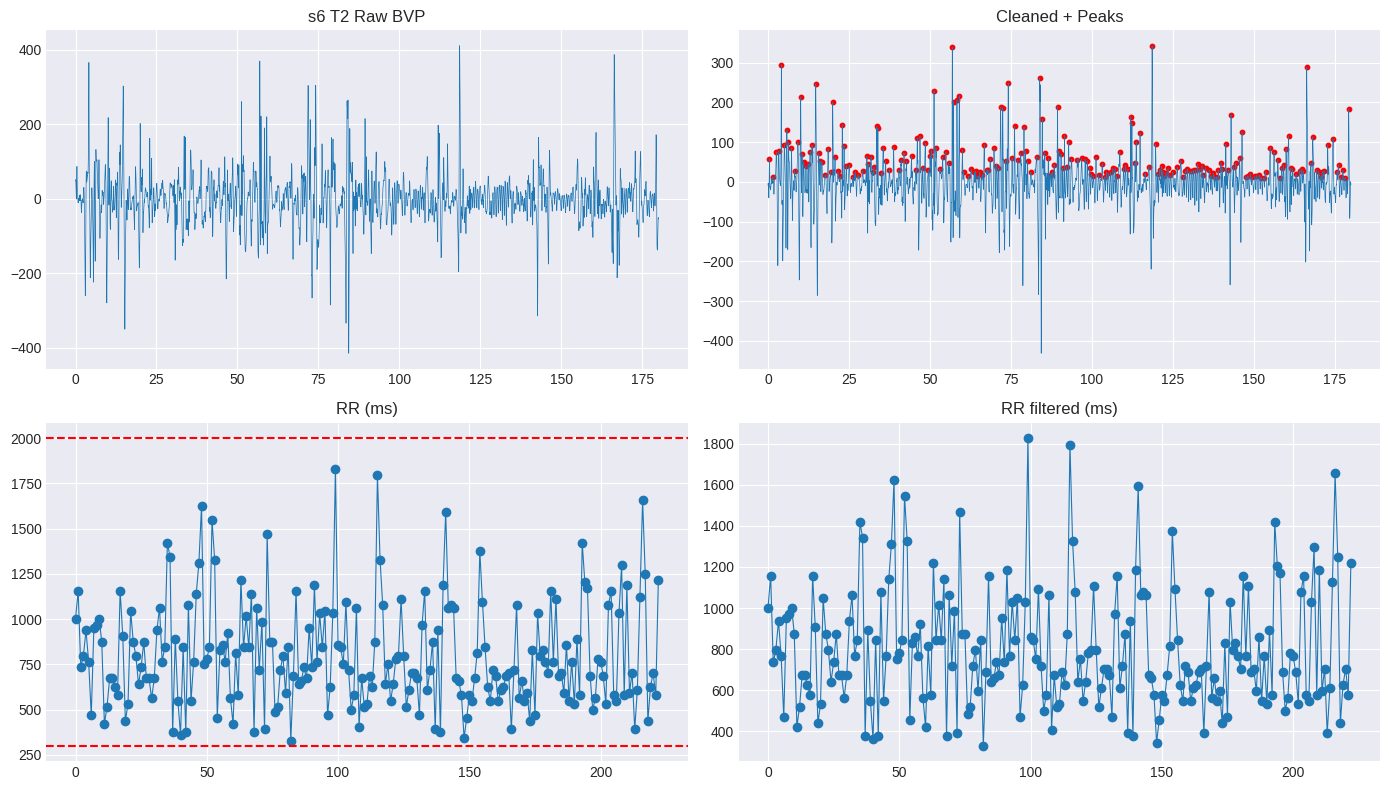

Peaks: 224 | RR: 223 | RR_filtered: 223
Summary: {'subject_id': '6', 'task': 'T2', 'signal_sec': 180.0, 'peaks': 224, 'rr_total': 223, 'rr_filtered': 223, 'windows': 3}


,HRV_SDNN,HRV_RMSSD,HRV_pNN50,HRV_MeanNN,HRV_HF,HRV_LF,HRV_LFHF,HRV_TP,HRV_SampEn,HRV_ApEn,HR_mean,subject_id,task,label,window_index,window_start_sec,window_end_sec,rr_count_window,RR_mean_ms_window,RR_sd_ms_window
0,294.897409,383.495279,86.986301,821.275685,0.061612,0.065587,1.064517,0.133319,2.226424,0.763290,73.057076,6,T2,1,0,0.0,120.000000,146,821.275685,293.885752
1,291.190031,351.536283,85.333333,792.395833,0.035437,0.067319,1.899710,0.106745,1.758815,0.774166,75.719732,6,T2,1,1,60.0,178.859375,150,792.395833,290.217774
2,277.687831,335.861183,85.526316,767.064145,0.088160,0.046173,0.523738,0.139827,1.945910,0.521963,78.220316,6,T2,1,2,120.0,178.859375,76,767.064145,275.854888


In [49]:
# DEMO on one subject-task 
demo_sid, demo_task = 6, 'T2'
demo_df, demo_sum = process_task_file(demo_sid, demo_task, plot=True)
print('Summary:', demo_sum)
display(demo_df.head())

In [50]:
# BATCH PROCESS ALL SUBJECTS & TASKS

def batch_process_all(subjects=SUBJECTS, tasks=TASKS, base=DATA_PATH):
    rows = []
    summaries = []
    sr_rows = []
    for sid in subjects:
        info = load_subject_info(sid, base)
        sr = load_self_reported_anxiety(sid, base)
        for t in tasks:
            df_w, sum_w = process_task_file(sid, t, base=base, plot=False)
            if not df_w.empty:
                for k,v in info.items():
                    df_w[k] = v
                for k,v in sr.items():
                    if k != 'subject_id': df_w[k] = v
                rows.append(df_w)
            sum_w['windows_kept'] = 0 if df_w.empty else int(df_w.shape[0])
            summaries.append(sum_w)
        sr_rows.append(sr)
    full = pd.concat(rows, axis=0).reset_index(drop=True) if rows else pd.DataFrame()
    summary_df = pd.DataFrame(summaries)
    sr_df = pd.DataFrame(sr_rows).drop_duplicates('subject_id')
    return full, summary_df, sr_df

features_df, task_summary_df, self_reports_df = batch_process_all()
print('features_df shape:', features_df.shape)
display(task_summary_df.head())
display(self_reports_df.head())

# Distribution
print('Label distribution:', features_df['label'].value_counts().to_dict())
print('Scenario counts:', features_df['scenario'].value_counts(dropna=False).to_dict())

features_df shape: (206, 33)


,subject_id,task,signal_sec,peaks,rr_total,rr_filtered,windows,windows_kept
0,6,T1,180.0,266,265,265,3,3
1,6,T2,180.0,224,223,223,3,3
2,6,T3,180.0,290,289,289,3,3
3,7,T1,180.0,211,210,210,3,3
4,7,T2,180.0,215,214,213,3,3


,subject_id,cognitive_pre,cognitive_post,cognitive_change,somatic_pre,somatic_post,somatic_change,confidence_pre,confidence_post,confidence_change
0,6,1.571,1.286,-0.285,2.000,2.428,0.428,2.111,2.444,0.333
1,7,2.000,1.714,-0.286,1.714,1.571,-0.143,2.222,2.000,-0.222
2,8,1.857,2.000,0.143,1.428,1.571,0.143,3.222,2.778,-0.444
3,9,3.714,3.286,-0.428,2.428,3.000,0.572,1.778,1.333,-0.445
4,10,2.143,2.714,0.571,1.714,2.428,0.714,2.222,1.778,-0.444


Label distribution: {1: 138, 0: 68}
Scenario counts: {'test': 107, 'ctrl': 90, 'unknown': 9}


In [51]:
# Persist preprocessed files 
features_path = OUT_DIR / 'ubfc_features_core10.csv'  
task_sum_path = OUT_DIR / 'ubfc_task_summaries.csv'
sr_path = OUT_DIR / 'ubfc_self_reports.csv'

features_df.to_csv(features_path, index=False)
task_summary_df.to_csv(task_sum_path, index=False)
self_reports_df.to_csv(sr_path, index=False)

print('Saved:', features_path, task_sum_path, sr_path)


Saved: /teamspace/studios/this_studio/ubfc_testing/output/ubfc_features_core10.csv /teamspace/studios/this_studio/ubfc_testing/output/ubfc_task_summaries.csv /teamspace/studios/this_studio/ubfc_testing/output/ubfc_self_reports.csv


In [52]:
features_df.columns = features_df.columns.str.lower().str.replace(" ", "_")

In [53]:
features_df.isnull().sum()

hrv_sdnn             0
hrv_rmssd            0
hrv_pnn50            0
hrv_meannn           0
hrv_hf               0
hrv_lf               3
hrv_lfhf             3
hrv_tp               0
hrv_sampen           0
hrv_apen             0
hr_mean              0
subject_id           0
task                 0
label                0
window_index         0
window_start_sec     0
window_end_sec       0
rr_count_window      0
rr_mean_ms_window    0
rr_sd_ms_window      0
gender               9
scenario             0
date                 9
time                 9
cognitive_pre        0
cognitive_post       0
cognitive_change     0
somatic_pre          0
somatic_post         0
somatic_change       0
confidence_pre       0
confidence_post      0
confidence_change    0
dtype: int64

In [54]:
features_df["hrv_lf"] = features_df["hrv_lf"].fillna(0)
features_df["hrv_lfhf"] = features_df["hrv_lfhf"].fillna(0)

In [114]:
from sklearn.model_selection import train_test_split

In [115]:
df_full_train, df_test = train_test_split(features_df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [116]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [117]:
y_train = df_train.label.values
y_val = df_val.label.values
y_test = df_test.label.values

In [118]:
del df_train['label']
del df_val['label']
del df_test['label']

In [119]:
df_train.head()

,hrv_sdnn,hrv_rmssd,hrv_pnn50,hrv_meannn,hrv_hf,hrv_lf,hrv_lfhf,hrv_tp,hrv_sampen,hrv_apen,...,time,cognitive_pre,cognitive_post,cognitive_change,somatic_pre,somatic_post,somatic_change,confidence_pre,confidence_post,confidence_change
0,268.905637,361.624040,93.288591,805.264262,0.126030,0.033062,0.262336,0.176840,2.477302,0.745510,...,11_26_13,1.143,1.143,0.000,1.000,1.000,0.000,2.889,3.1111,0.2221
1,289.331432,332.461080,72.222222,784.939236,0.075017,0.058077,0.774184,0.139066,1.511458,0.578136,...,NaN,2.857,3.143,0.286,2.714,3.428,0.714,1.222,1.0000,-0.2220
2,301.038272,423.697597,84.137931,826.400862,0.128338,0.057319,0.446625,0.198993,1.693025,0.762088,...,14_21_41,2.143,2.000,-0.143,1.571,2.000,0.429,2.333,2.6670,0.3340
3,305.528477,436.909678,87.234043,816.156915,0.088864,0.029811,0.335471,0.136544,2.064626,0.674080,...,16_25_08,2.000,2.143,0.143,1.857,2.143,0.286,1.778,1.4440,-0.3340
4,328.341118,405.949408,56.250000,754.882812,0.049657,0.012999,0.261776,0.064798,0.460652,0.446877,...,09_57_37,1.857,2.143,0.286,1.000,1.143,0.143,2.778,2.5550,-0.2230


In [120]:
# EDA

In [121]:
df_full_train = df_full_train.reset_index(drop=True)

In [122]:
df_full_train.isnull().sum()

hrv_sdnn             0
hrv_rmssd            0
hrv_pnn50            0
hrv_meannn           0
hrv_hf               0
hrv_lf               0
hrv_lfhf             0
hrv_tp               0
hrv_sampen           0
hrv_apen             0
hr_mean              0
subject_id           0
task                 0
label                0
window_index         0
window_start_sec     0
window_end_sec       0
rr_count_window      0
rr_mean_ms_window    0
rr_sd_ms_window      0
gender               9
scenario             0
date                 9
time                 9
cognitive_pre        0
cognitive_post       0
cognitive_change     0
somatic_pre          0
somatic_post         0
somatic_change       0
confidence_pre       0
confidence_post      0
confidence_change    0
dtype: int64

In [123]:
df_full_train.label.value_counts(normalize=True) # 1 stress and 0 no stress

label
1    0.670732
0    0.329268
Name: proportion, dtype: float64

In [124]:
df_full_train.label.mean()

df_full_train["rr_mean_ms_window"].head()

0    747.851562
1    825.804455
2    966.145833
3    847.196691
4    617.268880
Name: rr_mean_ms_window, dtype: float64

In [125]:
df_full_train.dtypes

"""
Important

hrv_sdnn             float64
hrv_rmssd            float64
hrv_pnn50            float64
hrv_meannn           float64
hrv_hf               float64
hrv_lf               float64
hrv_lfhf             float64
hrv_tp               float64
hrv_sampen           float64
hrv_apen             float64

gender_encoded
"""

'\nImportant\n\nhrv_sdnn             float64\nhrv_rmssd            float64\nhrv_pnn50            float64\nhrv_meannn           float64\nhrv_hf               float64\nhrv_lf               float64\nhrv_lfhf             float64\nhrv_tp               float64\nhrv_sampen           float64\nhrv_apen             float64\n\ngender_encoded\n'

In [126]:
df_full_train["gender"].unique()

array(['f', 'm', nan], dtype=object)

In [127]:
df_full_train["gender"] = df_full_train["gender"].fillna("u")

In [128]:
numerical = [
    'hrv_sdnn',
    'hrv_rmssd',
    'hrv_pnn50',
    'hrv_meannn',
    'hrv_hf',
    'hrv_lf',
    'hrv_lfhf',
    'hrv_tp',
    'hrv_sampen',
    'hrv_apen'
]

categorical = ['gender']

In [129]:
df_full_train[numerical+categorical].isnull().sum()

hrv_sdnn      0
hrv_rmssd     0
hrv_pnn50     0
hrv_meannn    0
hrv_hf        0
hrv_lf        0
hrv_lfhf      0
hrv_tp        0
hrv_sampen    0
hrv_apen      0
gender        0
dtype: int64

In [130]:
inf_counts = (df_full_train[numerical + categorical] == np.inf).sum()
neg_inf_counts = (df_full_train[numerical + categorical] == -np.inf).sum()

print("Positive inf:")
print(inf_counts[inf_counts > 0])

print("\nNegative inf:")
print(neg_inf_counts[neg_inf_counts > 0])

Positive inf:
hrv_sampen    3
dtype: int64

Negative inf:
hrv_sampen    1
dtype: int64


In [131]:
df_full_train[numerical] = df_full_train[numerical].replace([np.inf, -np.inf], np.nan)
df_full_train[numerical] = df_full_train[numerical].fillna(df_full_train[numerical].median())

In [132]:
df_full_train[numerical + categorical].head()

,hrv_sdnn,hrv_rmssd,hrv_pnn50,hrv_meannn,hrv_hf,hrv_lf,hrv_lfhf,hrv_tp,hrv_sampen,hrv_apen,gender
0,151.322535,240.023011,77.500000,747.851562,0.108526,0.019446,0.179186,0.172993,2.189790,0.664428,f
1,289.441358,422.615092,85.148515,825.804455,0.101024,0.049400,0.488991,0.165604,2.288196,0.618158,f
2,308.959910,419.780583,90.000000,966.145833,0.122805,0.043222,0.351954,0.189379,1.693172,0.193491,f
3,229.526110,336.994768,89.705882,847.196691,0.124397,0.019358,0.155615,0.180541,2.251292,0.293922,f
4,83.953058,121.946088,20.833333,617.268880,0.042786,0.056515,1.320855,0.125206,0.702044,0.744823,f


In [133]:
inf_counts = (df_full_train[numerical + categorical] == np.inf).sum()
neg_inf_counts = (df_full_train[numerical + categorical] == -np.inf).sum()

print("Positive inf:")
print(inf_counts[inf_counts > 0])

print("\nNegative inf:")
print(neg_inf_counts[neg_inf_counts > 0])

Positive inf:
Series([], dtype: int64)

Negative inf:
Series([], dtype: int64)


In [134]:
df_full_train['gender'].value_counts(normalize=True)

gender
f    0.798780
m    0.146341
u    0.054878
Name: proportion, dtype: float64

In [135]:
stress_female = df_full_train[df_full_train.gender == 'f'].label.mean()
stress_female

np.float64(0.6717557251908397)

In [136]:
stress_male = df_full_train[df_full_train.gender == 'm'].label.mean()
stress_male

np.float64(0.6666666666666666)

In [137]:
global_stress = df_full_train.label.mean()

In [138]:
print("Male", (global_stress-stress_male))
print("Female", (global_stress-stress_female))

Male 0.004065040650406582
Female -0.0010240178737664918


In [139]:
"""
stress_male   = 0.6667
stress_female = 0.6718

Count
f: 84.5%  
m: 15.5%

Drift
Male 0.004065040650406582
Female -0.0010240178737664918

The imbalance comes from gender count, not from label distribution.
Gender is not predictive. Take only numerical!
"""

'\nstress_male   = 0.6667\nstress_female = 0.6718\n\nCount\nf: 84.5%  \nm: 15.5%\n\nDrift\nMale 0.004065040650406582\nFemale -0.0010240178737664918\n\nThe imbalance comes from gender count, not from label distribution.\nGender is not predictive. Take only numerical!\n'

In [140]:
from sklearn.metrics import mutual_info_score

In [141]:
def mutual_info_stress_score(series):
    return mutual_info_score(series, df_full_train.label)

In [142]:
mi = df_full_train[numerical].apply(mutual_info_stress_score)
mi.sort_values(ascending=False)

hrv_hf        0.633659
hrv_lf        0.633659
hrv_lfhf      0.633659
hrv_sdnn      0.633659
hrv_rmssd     0.633659
hrv_meannn    0.633659
hrv_apen      0.633659
hrv_tp        0.633659
hrv_pnn50     0.616753
hrv_sampen    0.608300
dtype: float64

In [144]:
ps = df_full_train[numerical].corrwith(df_full_train.label).abs()
ps.sort_values(ascending=False)

hrv_sdnn      0.605393
hrv_rmssd     0.577955
hrv_pnn50     0.456597
hrv_lf        0.300606
hrv_apen      0.257012
hrv_meannn    0.184816
hrv_tp        0.184090
hrv_hf        0.132321
hrv_sampen    0.048139
hrv_lfhf      0.045967
dtype: float64

In [ ]:
"""
MI says all are equally important
Pearson says HRV_SDNN and HRV_RMSSD are gold mine and don't give shit about
hrv_sampen and hrv_lfhf
"""

In [152]:
for name, df in zip(['train','val','test'], [df_train, df_val, df_test]):
    pos_inf = df[numerical].isin([np.inf]).sum()
    neg_inf = df[numerical].isin([-np.inf]).sum()
    print(f"{name} positive inf:\n", pos_inf[pos_inf>0])
    print(f"{name} negative inf:\n", neg_inf[neg_inf>0])

train positive inf:
 hrv_sampen    3
dtype: int64
train negative inf:
 hrv_sampen    1
dtype: int64
val positive inf:
 Series([], dtype: int64)
val negative inf:
 Series([], dtype: int64)
test positive inf:
 Series([], dtype: int64)
test negative inf:
 Series([], dtype: int64)


In [153]:
finite_vals = df_train['hrv_sampen'].replace([np.inf, -np.inf], np.nan)
max_val = finite_vals.max()
min_val = finite_vals.min()

df_train['hrv_sampen'].replace(np.inf, max_val, inplace=True)
df_train['hrv_sampen'].replace(-np.inf, min_val, inplace=True)

In [154]:
np.isinf(df_train[numerical]).sum()


hrv_sdnn      0
hrv_rmssd     0
hrv_pnn50     0
hrv_meannn    0
hrv_hf        0
hrv_lf        0
hrv_lfhf      0
hrv_tp        0
hrv_sampen    0
hrv_apen      0
dtype: int64

In [155]:
from sklearn.linear_model import LogisticRegression

In [161]:
X_train = df_train[numerical]
X_val = df_val[numerical]
X_test = df_test[numerical]

In [157]:
model = LogisticRegression()
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [158]:
model.intercept_[0]

np.float64(2.2575540239249836)

In [159]:
model.coef_[0].round(3)

array([ 0.012,  0.012,  0.015, -0.012, -0.052,  0.331,  1.097,  0.382,
        0.49 , -0.575])

In [222]:
y_pred_val = model.predict_proba(X_val)[:, 1]

In [221]:
from sklearn.metrics import accuracy_score

In [ ]:
y_val

array([0.08363106, 0.9687436 , 0.76873508, 0.05934657, 0.96681465,
       0.29911231, 0.98849578, 0.96168929, 0.23463093, 0.97941691,
       0.93922533, 0.96370006, 0.84644041, 0.93887307, 0.22099796,
       0.07322108, 0.64435491, 0.97708969, 0.78212809, 0.34918616,
       0.46894868, 0.69186331, 0.77452807, 0.7818244 , 0.87636346,
       0.91736052, 0.97896088, 0.14772868, 0.88623824, 0.16561431,
       0.67531077, 0.95105405, 0.30627757, 0.72871186, 0.38262994,
       0.7792996 , 0.19430104, 0.96043992, 0.15393748, 0.87843453,
       0.66286926])

In [223]:
accuracy_score(y_val, y_pred_val >= 0.5)

0.7317073170731707

In [210]:
X_full_train = df_full_train[numerical]
y_full_train = df_full_train.label.values

In [211]:
model = LogisticRegression()
model.fit(X_full_train, y_full_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [224]:
y_pred_test = model.predict_proba(X_test)[:, 1]

In [225]:
accuracy_score(y_test, y_pred_test >= 0.5)

0.8333333333333334

In [214]:
"""
Acc is 73.17% in Val using Logestic
Acc is 83.3% in test using Logestic
"""

'\nAcc is 73.17% in Val using Logestic\nAcc is 83.3% in test using Logestic\n'

In [215]:
# Evaluating the model

In [227]:
thresholds = np.linspace(0, 1, 21)

scores = []
formatted = []

for t in thresholds:
    score = accuracy_score(y_val, y_pred_val >= t)
    formatted.append('%.2f %.3f' % (t, score))
    scores.append(score)
print("val")
formatted 

val


['0.00 0.634',
 '0.05 0.634',
 '0.10 0.707',
 '0.15 0.732',
 '0.20 0.805',
 '0.25 0.805',
 '0.30 0.829',
 '0.35 0.780',
 '0.40 0.756',
 '0.45 0.756',
 '0.50 0.732',
 '0.55 0.732',
 '0.60 0.732',
 '0.65 0.756',
 '0.70 0.732',
 '0.75 0.707',
 '0.80 0.634',
 '0.85 0.659',
 '0.90 0.634',
 '0.95 0.561',
 '1.00 0.366']

In [ ]:
"""
Right cuts can be
'0.20 0.805',
'0.25 0.805',
'0.30 0.829',
"""

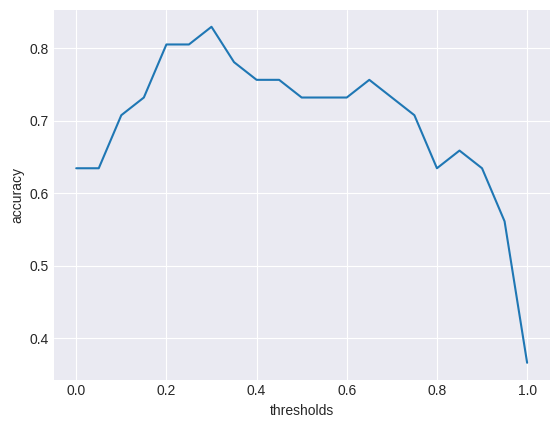

In [198]:
plt.plot(thresholds, scores)
plt.xlabel("thresholds")
plt.ylabel("accuracy")
plt.show()

In [199]:
optimal_threshold = thresholds[np.argmax(scores)]
print("Optimal threshold:", optimal_threshold)

Optimal threshold: 0.30000000000000004


In [228]:
accuracy_score(y_val, y_pred_val >= 0.3)

0.8292682926829268

In [229]:
accuracy_score(y_test, y_pred_test >= 0.3)

0.8095238095238095

In [204]:
thresholds = np.linspace(0, 1, 21)

scores = []
formatted = []

for t in thresholds:
    score = accuracy_score(y_test, y_pred >= t)
    formatted.append('%.2f %.3f' % (t, score))
    scores.append(score)

print("Test")
formatted 

Test


['0.00 0.667',
 '0.05 0.667',
 '0.10 0.690',
 '0.15 0.810',
 '0.20 0.833',
 '0.25 0.833',
 '0.30 0.810',
 '0.35 0.857',
 '0.40 0.857',
 '0.45 0.833',
 '0.50 0.833',
 '0.55 0.810',
 '0.60 0.810',
 '0.65 0.786',
 '0.70 0.738',
 '0.75 0.690',
 '0.80 0.667',
 '0.85 0.667',
 '0.90 0.643',
 '0.95 0.500',
 '1.00 0.333']

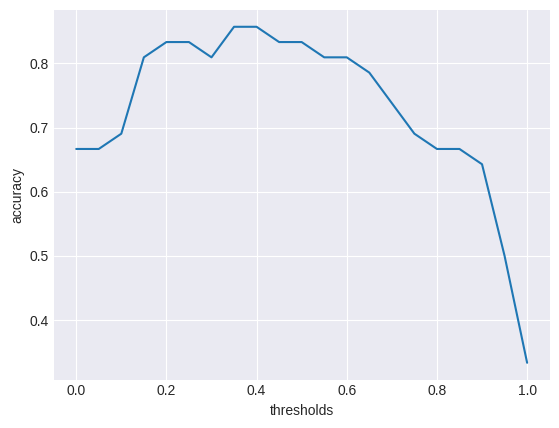

In [203]:
plt.plot(thresholds, scores)
plt.xlabel("thresholds")
plt.ylabel("accuracy")
plt.show()

In [ ]:
"""Val set peak acc: 0.829 at threshold 0.30
Test peak acc: 0.857 at thresholds 0.35–0.40"""

In [249]:
from sklearn.metrics import confusion_matrix
threshold = 0.32

In [250]:
cm_val = confusion_matrix(y_val, y_pred_val >= threshold)
print("Val cm")
print(cm_val)

Val cm
[[ 9  6]
 [ 2 24]]


In [251]:
cm_test = confusion_matrix(y_test, y_pred_test >= threshold)
print("Test Cm:")
print(cm_test)

Test Cm:
[[ 9  5]
 [ 1 27]]


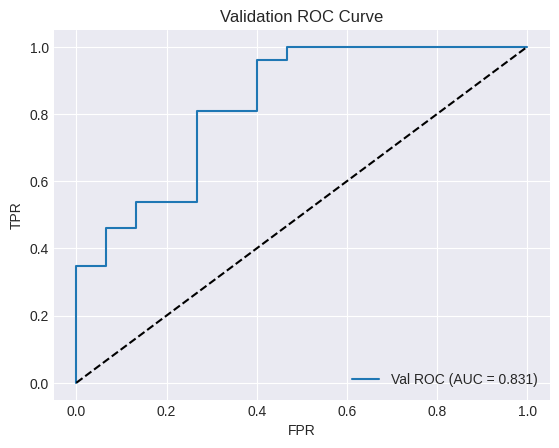

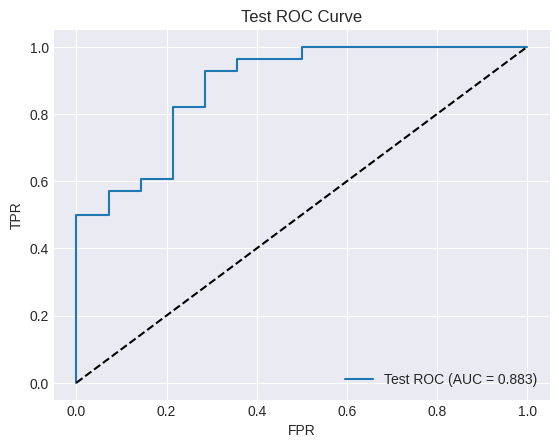

In [256]:
from sklearn.metrics import roc_curve, roc_auc_score

# Validation
fpr_val, tpr_val, _ = roc_curve(y_val, y_pred_val)  # probabilities
auc_val = roc_auc_score(y_val, y_pred_val)
plt.figure()
plt.plot(fpr_val, tpr_val, label=f'Val ROC (AUC = {auc_val:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Validation ROC Curve')
plt.legend()
plt.show()

# Test
fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_test)
auc_test = roc_auc_score(y_test, y_pred_test)
plt.figure()
plt.plot(fpr_test, tpr_test, label=f'Test ROC (AUC = {auc_test:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Test ROC Curve')
plt.legend()
plt.show()


In [ ]:
"""
Personal take:

Val set peak acc: 0.829 at threshold 0.30
Test peak acc: 0.857 at thresholds 0.35–0.40

It seems like if we can consider good features after analyzing it well even LR is good shot.

"""